In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [3]:
data = pd.read_csv("data.csv",  encoding ="utf-8")

In [4]:
data.describe()

,Unnamed: 0,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,is_goal,shot_id_number,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
count,30697.000000,29134.000000,29236.000000,29157.000000,29135.000000,29211.000000,29180.000000,29103.000000,29130.000000,24429.000000,29134.000000,3.069700e+04,3.069700e+04,29162.000000,29158.000000,29204.000000,29158.000000,29129.000000
mean,15348.000000,249.576028,7.383876,91.126933,4.883233,2.519359,0.145956,28.329382,33.448884,0.445331,15368.581039,2.476407e+07,1.610613e+09,18.204615,15.994109,16.599402,39.027303,38.801852
std,8861.604943,150.186019,110.263049,87.676395,3.452533,1.153976,0.353068,17.470663,9.369656,0.497013,8866.520772,7.755175e+06,0.000000e+00,29.416973,29.676815,35.172016,29.835284,18.787711
min,0.000000,2.000000,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,1.000000,2.000001e+07,1.610613e+09,0.000000,1.000000,0.000000,0.000000,9.400000
25%,7674.000000,111.000000,-68.000000,4.000000,2.000000,1.000000,0.000000,13.000000,25.000000,0.000000,7693.250000,2.050008e+07,1.610613e+09,3.000000,2.000000,0.000000,17.000000,26.000000
50%,15348.000000,254.000000,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,35.000000,0.000000,15378.500000,2.090035e+07,1.610613e+09,6.000000,3.000000,0.000000,35.000000,36.000000
75%,23022.000000,369.000000,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,41.000000,1.000000,23055.750000,2.960047e+07,1.610613e+09,11.000000,4.000000,1.000000,52.000000,44.000000
max,30696.000000,659.000000,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,99.000000,1.000000,30697.000000,4.990009e+07,1.610613e+09,128.761600,118.360000,141.352320,144.785600,115.728000


In [5]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.shape

(30697, 27)

In [6]:
data.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,...,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,...,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,...,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,...,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,...,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,...,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [7]:
## Team Name and TeamId have only 1 value, and matchid is unique , with no impact on the predicting algorithm 
## hence deleting them..
data = data.drop(['team_id', 'team_name','match_id','match_event_id'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 23 columns):
location_x               29236 non-null float64
location_y               29157 non-null float64
remaining_min            29135 non-null float64
power_of_shot            29211 non-null float64
knockout_match           29180 non-null float64
game_season              24835 non-null object
remaining_sec            29103 non-null float64
distance_of_shot         29130 non-null float64
is_goal                  24429 non-null float64
area_of_shot             29195 non-null object
shot_basics              29122 non-null object
range_of_shot            29133 non-null object
date_of_game             29147 non-null object
home/away                29200 non-null object
shot_id_number           29134 non-null float64
lat/lng                  29132 non-null object
type_of_shot             15417 non-null object
type_of_combined_shot    15280 non-null object
remaining_min.1          29162 non-n

In [8]:
## Dropping duplicate columns with same names.. ##TODO : check this later..
data = data.drop(['remaining_min.1','power_of_shot.1','knockout_match.1','remaining_sec.1','distance_of_shot.1'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 18 columns):
location_x               29236 non-null float64
location_y               29157 non-null float64
remaining_min            29135 non-null float64
power_of_shot            29211 non-null float64
knockout_match           29180 non-null float64
game_season              24835 non-null object
remaining_sec            29103 non-null float64
distance_of_shot         29130 non-null float64
is_goal                  24429 non-null float64
area_of_shot             29195 non-null object
shot_basics              29122 non-null object
range_of_shot            29133 non-null object
date_of_game             29147 non-null object
home/away                29200 non-null object
shot_id_number           29134 non-null float64
lat/lng                  29132 non-null object
type_of_shot             15417 non-null object
type_of_combined_shot    15280 non-null object
dtypes: float64(9), object(9)
memory

In [9]:
data.isnull().sum()

location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
date_of_game              1550
home/away                 1497
shot_id_number            1563
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
dtype: int64

,Total,Percent
type_of_combined_shot,15417,0.502231
type_of_shot,15280,0.497769
is_goal,6268,0.204189
game_season,5862,0.190963
remaining_sec,1594,0.051927


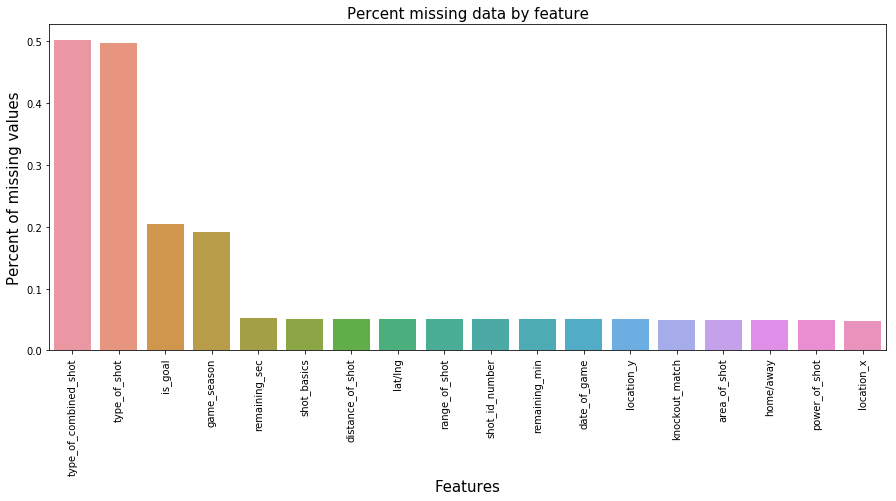

In [10]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [11]:
# There are now 2 columns having approx 50% missing values - 

# let's have a look at a few entries in the columns
data.loc[:, ['type_of_shot', 'type_of_combined_shot']].head()

,type_of_shot,type_of_combined_shot
0,shot - 30,NaN
1,shot - 45,NaN
2,shot - 25,NaN
3,NaN,shot - 3
4,NaN,shot - 1


In [12]:
### columns are missing in the manner if 1 is having the value other is missing it.. 
### hence merging the values and dropping another
data.loc[data['type_of_shot'].isnull(),'type_of_shot'] = data['type_of_combined_shot']
data = data.drop(['type_of_combined_shot'], axis=1)

In [13]:
round(data.isnull().sum()/len(data.index), 2)*100

location_x           5.0
location_y           5.0
remaining_min        5.0
power_of_shot        5.0
knockout_match       5.0
game_season         19.0
remaining_sec        5.0
distance_of_shot     5.0
is_goal             20.0
area_of_shot         5.0
shot_basics          5.0
range_of_shot        5.0
date_of_game         5.0
home/away            5.0
shot_id_number       5.0
lat/lng              5.0
type_of_shot         0.0
dtype: float64

In [14]:
data.nunique()

location_x            488
location_y            450
remaining_min          12
power_of_shot           7
knockout_match          2
game_season            20
remaining_sec          60
distance_of_shot       73
is_goal                 2
area_of_shot            6
shot_basics             7
range_of_shot           5
date_of_game         1558
home/away              74
shot_id_number      29134
lat/lng                38
type_of_shot           57
dtype: int64

In [15]:
## deleting columns whose shot id number is empty
data['shot_id_number'].replace(' ', np.nan, inplace=True)
data= data.dropna(subset=['shot_id_number'])

In [16]:
## updating knockout column value to 0 if null/empty
data.loc[data['knockout_match'].isnull(),'knockout_match'] = 0

In [17]:
round(data.isnull().sum()/len(data.index), 2)*100

location_x           5.0
location_y           5.0
remaining_min        5.0
power_of_shot        5.0
knockout_match       0.0
game_season         19.0
remaining_sec        5.0
distance_of_shot     5.0
is_goal             20.0
area_of_shot         5.0
shot_basics          5.0
range_of_shot        5.0
date_of_game         5.0
home/away            5.0
shot_id_number       0.0
lat/lng              5.0
type_of_shot         0.0
dtype: float64

In [18]:
data['date_of_game'] =  data['date_of_game'].astype('datetime64[ns]')

In [19]:
data['game_season'] = data['game_season'].str.split('-').str[0]
data.loc[data['game_season'].isnull(),'game_season'] = data['date_of_game'].dt.year
data.loc[data['date_of_game'].isnull(),'date_of_game'] = data['game_season'].astype('datetime64[ns]') 

In [20]:
data['lat/lng'].replace(' ', np.nan, inplace=True)

In [21]:
data['latitude'] = data['lat/lng'].str.split(',').str[0]
data['longitude'] = data['lat/lng'].str.split(',').str[1]
data = data.drop(['lat/lng','date_of_game'], axis=1)

In [22]:
round(data.isnull().sum()/len(data.index), 2)*100

location_x           5.0
location_y           5.0
remaining_min        5.0
power_of_shot        5.0
knockout_match       0.0
game_season          1.0
remaining_sec        5.0
distance_of_shot     5.0
is_goal             20.0
area_of_shot         5.0
shot_basics          5.0
range_of_shot        5.0
home/away            5.0
shot_id_number       0.0
type_of_shot         0.0
latitude             5.0
longitude            5.0
dtype: float64

In [23]:
#data['date_of_game'].replace(' ', np.nan, inplace=True)
#data= data.dropna(subset=['date_of_game'])

In [24]:
## converting seconds to mins and dropping seconds column

data['remaining_sec'] = data['remaining_sec']/60
data['remaining_min'] = data['remaining_min'] + data['remaining_sec']
data = data.drop(['remaining_sec'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29134 entries, 0 to 30696
Data columns (total 16 columns):
location_x          27749 non-null float64
location_y          27670 non-null float64
remaining_min       26204 non-null float64
power_of_shot       27731 non-null float64
knockout_match      29134 non-null float64
game_season         28848 non-null object
distance_of_shot    27648 non-null float64
is_goal             23179 non-null float64
area_of_shot        27714 non-null object
shot_basics         27640 non-null object
range_of_shot       27651 non-null object
home/away           27720 non-null object
shot_id_number      29134 non-null float64
type_of_shot        29134 non-null object
latitude            27665 non-null object
longitude           27665 non-null object
dtypes: float64(8), object(8)
memory usage: 5.0+ MB


,Total,Percent
is_goal,5955,0.204400
remaining_min,2930,0.100570
shot_basics,1494,0.051280
distance_of_shot,1486,0.051006
range_of_shot,1483,0.050903


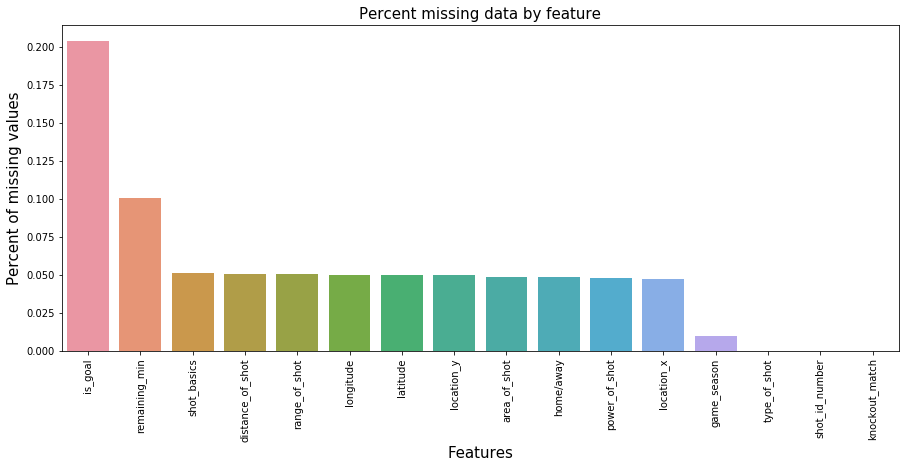

In [25]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29134 entries, 0 to 30696
Data columns (total 16 columns):
location_x          27749 non-null float64
location_y          27670 non-null float64
remaining_min       26204 non-null float64
power_of_shot       27731 non-null float64
knockout_match      29134 non-null float64
game_season         28848 non-null object
distance_of_shot    27648 non-null float64
is_goal             23179 non-null float64
area_of_shot        27714 non-null object
shot_basics         27640 non-null object
range_of_shot       27651 non-null object
home/away           27720 non-null object
shot_id_number      29134 non-null float64
type_of_shot        29134 non-null object
latitude            27665 non-null object
longitude           27665 non-null object
dtypes: float64(8), object(8)
memory usage: 5.0+ MB


In [27]:
filtered_data = data.loc[:, data.columns != 'is_goal']
is_goal = data['is_goal']
filtered_data.fillna(method='ffill',inplace=True)

In [28]:
data = pd.concat([filtered_data, is_goal], axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29134 entries, 0 to 30696
Data columns (total 16 columns):
location_x          29134 non-null float64
location_y          29134 non-null float64
remaining_min       29134 non-null float64
power_of_shot       29134 non-null float64
knockout_match      29134 non-null float64
game_season         29134 non-null object
distance_of_shot    29134 non-null float64
area_of_shot        29134 non-null object
shot_basics         29134 non-null object
range_of_shot       29134 non-null object
home/away           29134 non-null object
shot_id_number      29134 non-null float64
type_of_shot        29134 non-null object
latitude            29134 non-null object
longitude           29134 non-null object
is_goal             23179 non-null float64
dtypes: float64(8), object(8)
memory usage: 5.0+ MB


In [30]:
data.isnull().sum().sort_values(ascending=False)

is_goal             5955
longitude              0
latitude               0
type_of_shot           0
shot_id_number         0
home/away              0
range_of_shot          0
shot_basics            0
area_of_shot           0
distance_of_shot       0
game_season            0
knockout_match         0
power_of_shot          0
remaining_min          0
location_y             0
location_x             0
dtype: int64

In [31]:
### calculate home and away... and update the home away column based on the date of match values...
data['home/away'].replace(' ', np.nan, inplace=True)
data.loc[data['home/away'].str.contains('@'),'home/away'] = '0'
data.loc[data['home/away'].str.contains(' vs. '),'home/away'] = '1'
data["home/away"] = pd.to_numeric(data["home/away"])

In [32]:
data["game_season"] = pd.to_numeric(data["game_season"])

In [33]:
data['remaining_min'].replace(' ', np.nan, inplace=True)
data.loc[data['remaining_min'].isnull(),'remaining_min'] = 0

In [34]:
data.head()

,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,distance_of_shot,area_of_shot,shot_basics,range_of_shot,home/away,shot_id_number,type_of_shot,latitude,longitude,is_goal
0,167.0,72.0,10.450000,1.0,0.0,2000.0,38.0,Right Side(R),Mid Range,16-24 ft.,0,1.0,shot - 30,45.539131,-122.651648,NaN
1,-157.0,0.0,10.366667,1.0,0.0,2000.0,35.0,Left Side(L),Mid Range,8-16 ft.,0,2.0,shot - 45,45.539131,-122.651648,0.0
2,-101.0,135.0,7.750000,1.0,0.0,2000.0,36.0,Left Side Center(LC),Mid Range,16-24 ft.,0,3.0,shot - 25,45.539131,-122.651648,1.0
3,138.0,175.0,6.866667,1.0,0.0,2000.0,42.0,Right Side Center(RC),Mid Range,16-24 ft.,0,4.0,shot - 3,45.539131,-122.651648,0.0
4,0.0,0.0,6.866667,2.0,0.0,2000.0,20.0,Center(C),Goal Area,Less Than 8 ft.,0,5.0,shot - 1,45.539131,-122.651648,1.0


In [35]:
data['location_x'].replace(' ', np.nan, inplace=True)
data['location_y'].replace(' ', np.nan, inplace=True)
data.loc[data['location_x'].isnull(),'location_x'] = 0
data.loc[data['location_y'].isnull(),'location_y'] = 0

In [36]:
data.nunique()

location_x            488
location_y            448
remaining_min         715
power_of_shot           7
knockout_match          2
game_season            21
distance_of_shot       72
area_of_shot            6
shot_basics             7
range_of_shot           5
home/away               2
shot_id_number      29134
type_of_shot           57
latitude               38
longitude              38
is_goal                 2
dtype: int64

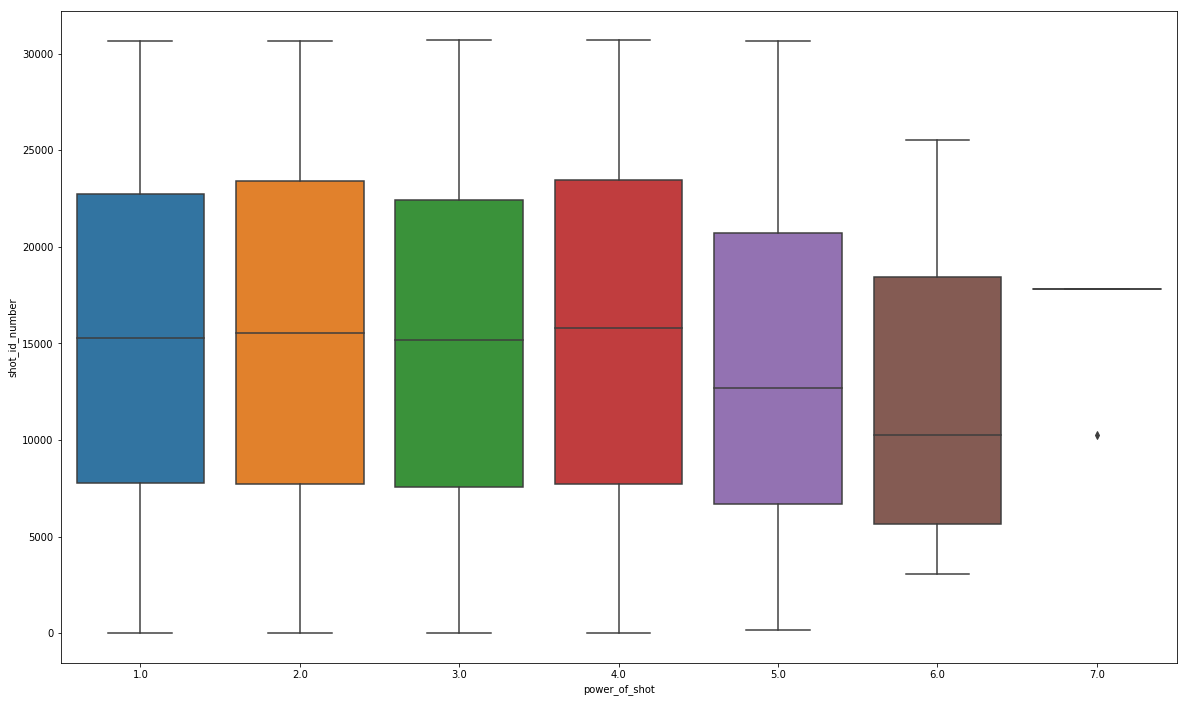

In [37]:
plt.figure(figsize=(20, 12))
plt.subplot(1,1,1)
sns.boxplot(x = 'power_of_shot', y = 'shot_id_number', data = data)

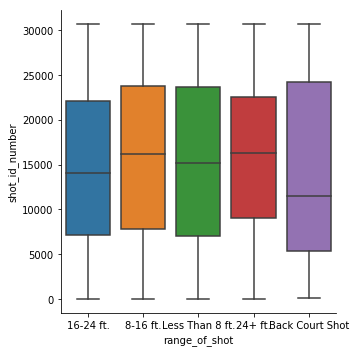

In [38]:
sns.catplot(x="range_of_shot", y="shot_id_number", kind="box", data=data);

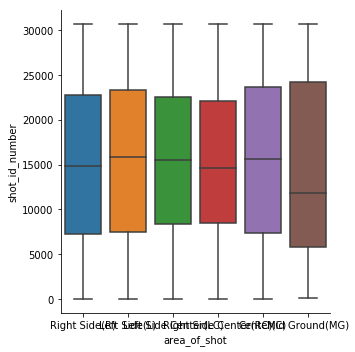

In [39]:
sns.catplot(x="area_of_shot", y="shot_id_number", kind="box", data=data);

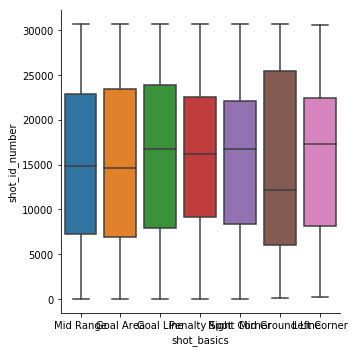

In [40]:
sns.catplot(x="shot_basics", y="shot_id_number", kind="box", data=data);

In [41]:
#data['shot_basics'].replace(' ', np.nan, inplace=True)
#data= data.dropna(subset=['shot_basics'])
#data['range_of_shot'].replace(' ', np.nan, inplace=True)
#data= data.dropna(subset=['range_of_shot'])
#data['area_of_shot'].replace(' ', np.nan, inplace=True)
#data= data.dropna(subset=['area_of_shot'])
#round(data.isnull().sum()/len(data.index), 2)*100

In [42]:
shot_basics = pd.get_dummies(data['shot_basics'], drop_first = True)
shot_basics.head()

,Goal Line,Left Corner,Mid Ground Line,Mid Range,Penalty Spot,Right Corner
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [43]:
data = pd.concat([data, shot_basics], axis = 1)

In [44]:
#range_of_shot = pd.get_dummies(data['range_of_shot'], drop_first = True)
#area_of_shot = pd.get_dummies(data['area_of_shot'], drop_first = True)

In [45]:
#data = pd.concat([data, range_of_shot], axis = 1)
#data = pd.concat([data, area_of_shot], axis = 1)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29134 entries, 0 to 30696
Data columns (total 22 columns):
location_x          29134 non-null float64
location_y          29134 non-null float64
remaining_min       29134 non-null float64
power_of_shot       29134 non-null float64
knockout_match      29134 non-null float64
game_season         29134 non-null float64
distance_of_shot    29134 non-null float64
area_of_shot        29134 non-null object
shot_basics         29134 non-null object
range_of_shot       29134 non-null object
home/away           29134 non-null int64
shot_id_number      29134 non-null float64
type_of_shot        29134 non-null object
latitude            29134 non-null object
longitude           29134 non-null object
is_goal             23179 non-null float64
Goal Line           29134 non-null uint8
Left Corner         29134 non-null uint8
Mid Ground Line     29134 non-null uint8
Mid Range           29134 non-null uint8
Penalty Spot        29134 non-null uint8
Right 

In [47]:
data.drop(['shot_basics'], axis = 1, inplace = True)

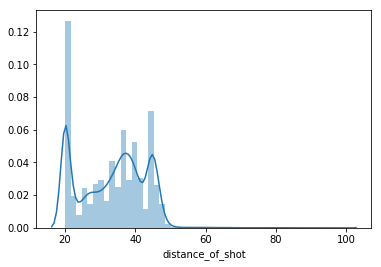

In [48]:
sns.distplot(data['distance_of_shot'])
plt.show()

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29134 entries, 0 to 30696
Data columns (total 21 columns):
location_x          29134 non-null float64
location_y          29134 non-null float64
remaining_min       29134 non-null float64
power_of_shot       29134 non-null float64
knockout_match      29134 non-null float64
game_season         29134 non-null float64
distance_of_shot    29134 non-null float64
area_of_shot        29134 non-null object
range_of_shot       29134 non-null object
home/away           29134 non-null int64
shot_id_number      29134 non-null float64
type_of_shot        29134 non-null object
latitude            29134 non-null object
longitude           29134 non-null object
is_goal             23179 non-null float64
Goal Line           29134 non-null uint8
Left Corner         29134 non-null uint8
Mid Ground Line     29134 non-null uint8
Mid Range           29134 non-null uint8
Penalty Spot        29134 non-null uint8
Right Corner        29134 non-null uint8
dtypes:

In [50]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data['type_of_shot'] = lb_make.fit_transform(data['type_of_shot'])
data['range_of_shot'] = lb_make.fit_transform(data['range_of_shot'])
data['area_of_shot'] = lb_make.fit_transform(data['area_of_shot'])

#### transforming the categorical values to linear ones.

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler = MinMaxScaler()

In [53]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['location_x', 'location_y', 'latitude', 'longitude']

data[num_vars] = scaler.fit_transform(data[num_vars])

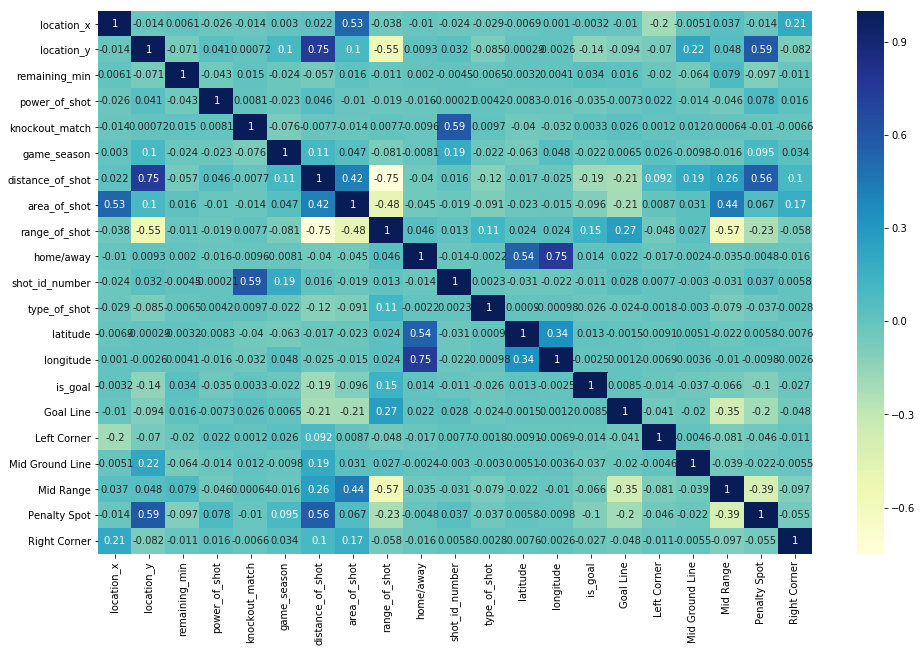

In [54]:
plt.figure(figsize = (16, 10))
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

## Running the test train split now, and fetching all isGoal null values for test data

In [55]:
data['is_goal'].replace(' ', np.nan, inplace=True)
test = data[data['is_goal'].isnull()]
test.shape

(5955, 21)

In [56]:
## drop all rows with is goal value is null, to run the machine learning algorithms
data= data.dropna(subset=['is_goal'])
data.head()

,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,distance_of_shot,area_of_shot,range_of_shot,home/away,...,type_of_shot,latitude,longitude,is_goal,Goal Line,Left Corner,Mid Ground Line,Mid Range,Penalty Spot,Right Corner
1,0.186747,0.052695,10.366667,1.0,0.0,2000.0,35.0,2,2,0,...,40,0.841814,0.008897,0.0,0,0,0,1,0,0
2,0.299197,0.214371,7.750000,1.0,0.0,2000.0,36.0,1,0,0,...,18,0.841814,0.008897,1.0,0,0,0,1,0,0
3,0.779116,0.262275,6.866667,1.0,0.0,2000.0,42.0,4,0,0,...,23,0.841814,0.008897,0.0,0,0,0,1,0,0
4,0.502008,0.052695,6.866667,2.0,0.0,2000.0,20.0,0,4,0,...,1,0.841814,0.008897,1.0,0,0,0,0,0,0
5,0.210843,0.039521,9.533333,3.0,0.0,2000.0,34.0,2,2,0,...,9,0.841814,0.008897,0.0,0,0,0,1,0,0


In [57]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)
df_train.head()

,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,distance_of_shot,area_of_shot,range_of_shot,home/away,...,type_of_shot,latitude,longitude,is_goal,Goal Line,Left Corner,Mid Ground Line,Mid Range,Penalty Spot,Right Corner
19613,0.514056,0.128144,9.566667,3.0,0.0,2012.0,26.0,0,4,0,...,7,0.544626,0.031860,0.0,1,0,0,0,0,0
8385,0.156627,0.263473,6.033333,3.0,0.0,2005.0,44.0,1,1,1,...,23,0.732851,0.992862,0.0,0,0,0,0,1,0
6990,0.425703,0.123353,4.916667,3.0,0.0,2004.0,27.0,0,4,1,...,23,0.732851,0.992862,0.0,1,0,0,0,0,0
18375,0.066265,0.231138,3.316667,2.0,0.0,2011.0,46.0,1,1,1,...,23,0.732851,0.992862,1.0,0,0,0,0,1,0
30259,0.612450,0.089820,9.100000,3.0,1.0,1999.0,26.0,0,4,0,...,52,0.155771,0.472531,0.0,1,0,0,0,0,0


In [58]:
y_train = df_train.pop('is_goal')
X_train = df_train

X_test= df_test.drop('is_goal', axis=1)
y_test= df_test['is_goal']

In [59]:
from sklearn.tree import DecisionTreeRegressor

# Define model
dtr_model = DecisionTreeRegressor()

# Fit model
dtr_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [60]:
print(X_train.head())
print("The predictions are")
print(dtr_model.predict(X_train.head()))

       location_x  location_y  remaining_min  power_of_shot  knockout_match  \
19613    0.514056    0.128144       9.566667            3.0             0.0   
8385     0.156627    0.263473       6.033333            3.0             0.0   
6990     0.425703    0.123353       4.916667            3.0             0.0   
18375    0.066265    0.231138       3.316667            2.0             0.0   
30259    0.612450    0.089820       9.100000            3.0             1.0   

       game_season  distance_of_shot  area_of_shot  range_of_shot  home/away  \
19613       2012.0              26.0             0              4          0   
8385        2005.0              44.0             1              1          1   
6990        2004.0              27.0             0              4          1   
18375       2011.0              46.0             1              1          1   
30259       1999.0              26.0             0              4          0   

       shot_id_number  type_of_shot  latitud

In [61]:
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics
import math

# Show model results of training set
y_hat = dtr_model.predict(X_train)
mae = metrics.mean_absolute_error(y_train,y_hat)
mse = metrics.mean_squared_error(y_train,y_hat)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", dtr_model.score(X_train,y_train))
print ("feature_importances:",dtr_model.feature_importances_)
print ("n_features:         ",dtr_model.n_features_)
print ("n_outputs:          ",dtr_model.n_outputs_)

TRAINING SET
MAE:                 0.0
RMSE:                0.0
r2:                  1.0
feature_importances: [0.11903245 0.11672655 0.17469509 0.04259525 0.00551363 0.0694604
 0.08293208 0.01678861 0.01461576 0.00708687 0.16121597 0.08093457
 0.0489075  0.04650743 0.00397164 0.00022164 0.00024935 0.00481439
 0.0030923  0.00063853]
n_features:          20
n_outputs:           1


In [62]:
### running the alogrithms on test data.
y_hat = dtr_model.predict(X_test)
mae = metrics.mean_absolute_error(y_test,y_hat)
mse = metrics.mean_squared_error(y_test,y_hat)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", dtr_model.score(X_test,y_test))

TEST SET
MAE:                 0.44017831463905666
RMSE:                0.6634593541725496
r2:                  -0.7844479310786531


### As per above data..considering the r2 is negative..running random forest to check the improvements, if any.

In [63]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [64]:
# fit
rfc.fit(X_train,y_train)
# Making predictions
predictions = rfc.predict(X_test)

In [65]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.60      0.77      0.68      3878
         1.0       0.55      0.37      0.44      3076

    accuracy                           0.59      6954
   macro avg       0.58      0.57      0.56      6954
weighted avg       0.58      0.59      0.57      6954



In [66]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[2967  911]
 [1942 1134]]


In [67]:
print(accuracy_score(y_test,predictions))

0.589732528041415


### accuracy is low, running K-Fold

In [68]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [69]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,param_max_depth,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.036498,0.003595,0.608136,2,{'max_depth': 2},2,0.613678,0.608320,0.607704,0.609245,0.601726,0.000796,0.000492,0.003828
1,0.072605,0.004189,0.609615,7,{'max_depth': 7},1,0.612754,0.608012,0.607704,0.615716,0.603884,0.001323,0.000399,0.004151
2,0.106914,0.005186,0.602342,12,{'max_depth': 12},3,0.611830,0.600616,0.596610,0.609553,0.593095,0.003420,0.000399,0.007258
3,0.134456,0.006582,0.592173,17,{'max_depth': 17},4,0.597043,0.590447,0.591371,0.594145,0.587855,0.003308,0.000489,0.003158


You can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score starts to decrease. The ensemble tries to overfit as we increase the max_depth.

Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest.

In [70]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [71]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,param_n_estimators,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.469722,0.023391,0.609122,100,{'n_estimators': 100},3,0.612754,0.610786,0.609553,0.609861,0.602651,0.040016,0.002163,0.003422
1,2.220710,0.122019,0.609307,500,{'n_estimators': 500},2,0.612446,0.610478,0.610169,0.609861,0.603576,0.135957,0.019321,0.003004
2,4.826449,0.206211,0.609492,900,{'n_estimators': 900},1,0.611830,0.610786,0.610478,0.610786,0.603576,0.982233,0.028863,0.002993
3,6.436811,0.298842,0.608875,1300,{'n_estimators': 1300},4,0.612138,0.610169,0.609861,0.610169,0.602035,0.339325,0.031842,0.003514


In [72]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


KeyError: 'mean_train_score'

<Figure size 432x288 with 0 Axes>

In [ ]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=300)

In [ ]:
# fit
rfc.fit(X_train,y_train)

In [ ]:
# predict
predictions = rfc.predict(X_test)

In [ ]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

In [ ]:
print(confusion_matrix(y_test,predictions))

In [ ]:
### running the alogrithms on test data.
y_hat = rfc.predict(X_test)
mae = metrics.mean_absolute_error(y_test,y_hat)
mse = metrics.mean_squared_error(y_test,y_hat)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", rfc.score(X_test,y_test))

In [ ]:
### running the alogrithms on test data which is missing the is goal information
target_test = test.pop('is_goal')
test = test

In [ ]:
test.head()

In [ ]:
print(test.shape)

In [ ]:
y_predict = rfc.predict(test)
y_predict

In [ ]:
submission2 = pd.DataFrame({'shot_id_number':test['shot_id_number'],'is_goal':y_predict})
submission2 = submission2[['shot_id_number', 'is_goal']]
submission2.is_goal.astype(int)
submission2.shot_id_number.astype(int)
submission2.head()

In [ ]:
#filename = 'ashutosh_tiwari_05031988_2.csv'
#submission2.to_csv(filename,index=False)

#print('Saved file: ' + filename)

In [ ]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [ ]:
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [ ]:
X = data.drop(['shot_id_number', 'is_goal'], axis=1).values
y = data.is_goal.values
test_id = test.shot_id_number.values
test2 = test.drop('shot_id_number', axis=1)

In [ ]:
sub = pd.DataFrame()
sub['shot_id_number'] = test_id
sub['is_goal'] = np.zeros_like(test_id)

In [ ]:
#sub.to_csv('ashutosh_tiwari_05031988_3.csv', index=False)


In [ ]:
# Fit the grid search to the data
model = xgboost.XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
op=pd.DataFrame(data={'shot_id_number':test['shot_id_number'],'is_goal':model.predict(test)})
op = op[['shot_id_number', 'is_goal']]
op.to_csv('ashutosh_tiwari_05031988_3.csv',index=False)